<a href="https://colab.research.google.com/github/koussayinsat12/EIF/blob/main/EIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Import Essential libraries

In [4]:
pip install eif

In [5]:
pip install igraph

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import eif as iso
import copy
import seaborn as sb
import pandas as pd
sb.set_style(style="whitegrid")
sb.set_color_codes()
ig.__version__

'0.10.6'

## Peripheral Anomaly point

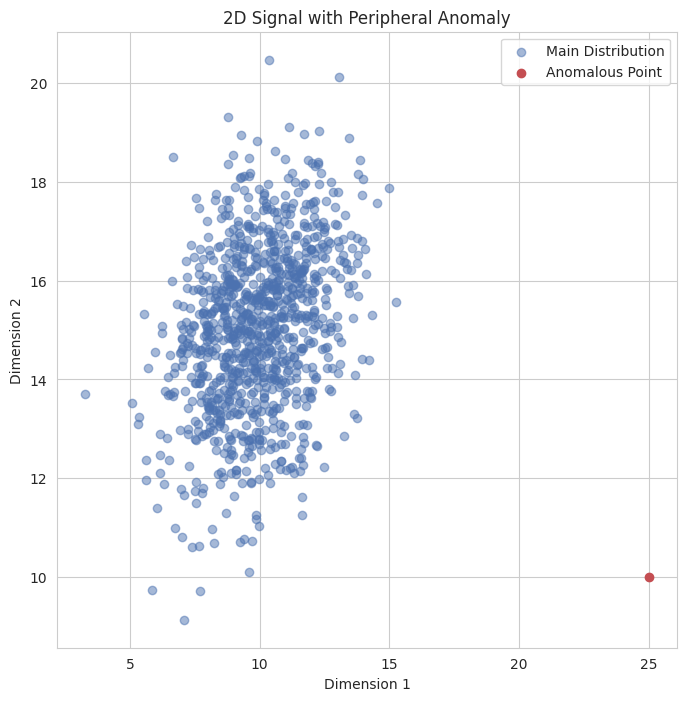

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the main distribution
main_mean = [10, 15]
main_cov = [[3, 1], [1, 3]]
num_points_main = 1000
anomaly_value = [25, 10]

main_distribution = np.random.multivariate_normal(main_mean, main_cov, num_points_main)

anomaly_point = np.array([anomaly_value])
plt.figure(figsize=(8, 8))
plt.scatter(main_distribution[:, 0], main_distribution[:, 1], label="Main Distribution", color='b', alpha=0.5)
plt.scatter(anomaly_point[:, 0], anomaly_point[:, 1], color='r', label="Anomalous Point")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.title("2D Signal with Peripheral Anomaly")
plt.grid(True)
plt.show()

In [41]:
main_distribution=np.vstack((main_distribution,anomaly_point))

In [42]:
main_distribution.shape

(1001, 2)

In [43]:
anomaly_point.shape

(1, 2)

In [44]:
main_distribution.shape

(1001, 2)

## Comparing performance between The iForest and the EIF

In [45]:
F0=iso.iForest(main_distribution, ntrees=500, sample_size=256, ExtensionLevel=0)#iForest
F1=iso.iForest(main_distribution, ntrees=500, sample_size=256, ExtensionLevel=1)#EIF

In [51]:
main_distribution.shape

(1001, 2)

In [52]:
anomaly_scores_0=F0.compute_paths(X_in=main_distribution)# anomaly score created by iForest
anomaly_scores_1=F1.compute_paths(X_in=main_distribution)# anomaly score created by EIF

In [53]:
anomaly_scores_0.shape

(1001,)

In [68]:
#To set the threshold I used the Median Absolute Deviation (MAD) method
def compute_mad(scores):
    median = np.median(scores)
    abs_deviations = np.abs(scores - median)
    mad = np.median(abs_deviations)
    return mad

def set_threshold(scores, scaling_factor=10):
    median = np.median(scores)
    mad = compute_mad(scores)
    threshold = median + (scaling_factor * mad)
    return threshold
threshold0=set_threshold(anomaly_scores_0)
threshold1=set_threshold(anomaly_scores_1)

In [69]:
x,y=main_distribution[:,0],main_distribution[:,1]
anomaly_indices_0 = np.where(anomaly_scores_0 >threshold0)[0]
anomaly_indices_1 = np.where(anomaly_scores_1 >threshold1)[0]


In [70]:
x.shape,y.shape

((1001,), (1001,))

In [71]:
main_distribution[1000,:]

array([25., 10.])

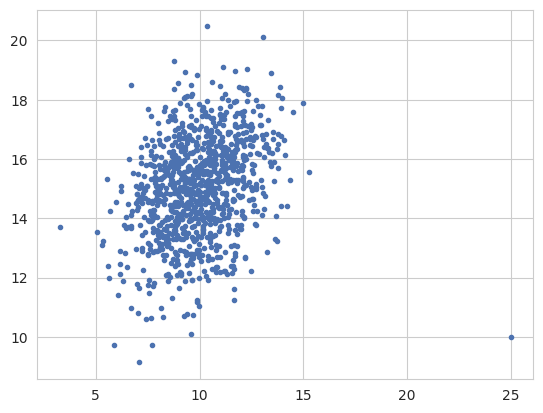

In [72]:
plt.plot(main_distribution[:,0],main_distribution[:,1],'b.')

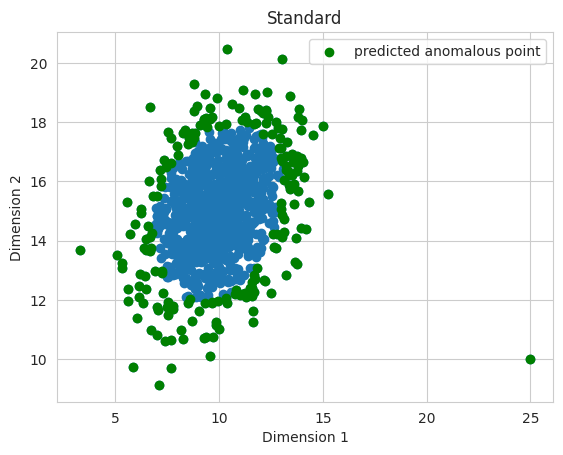

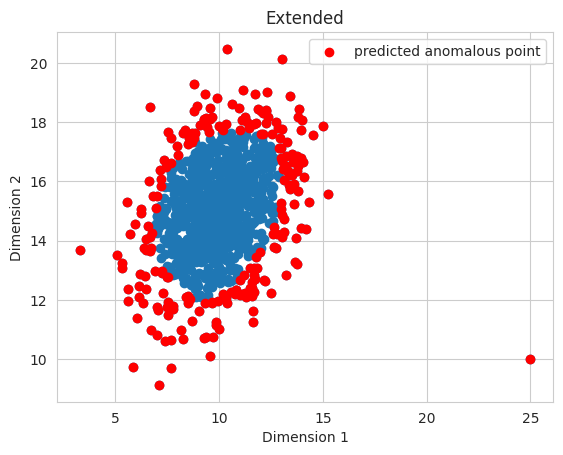

In [63]:
fig1 = plt.figure()
plt.scatter(x, y)
plt.scatter(x[anomaly_indices_0], y[anomaly_indices_0], color='green',label="predicted anomalous point")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.title('Standard')
plt.show()
fig2= plt.figure()
plt.scatter(x, y)
plt.scatter(x[anomaly_indices_1], y[anomaly_indices_1], color='red',label="predicted anomalous point")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.title('Extended')
plt.show()




### Score Maps

In [64]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)

def getVals(forest,x,sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]),i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

In [65]:
x,y=main_distribution[:,0],main_distribution[:,1]

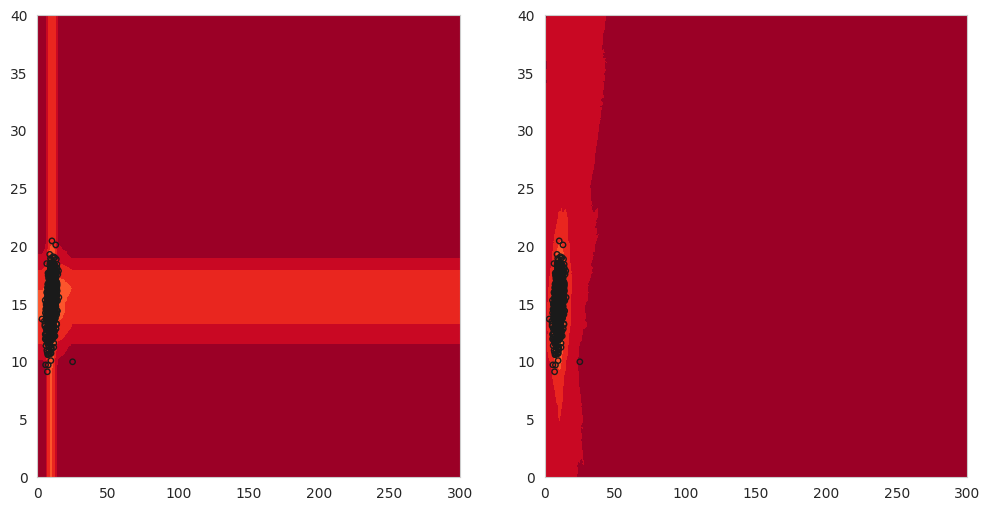

In [66]:
xx, yy = np.meshgrid(np.linspace(0, 300, 300), np.linspace(0, 40, 300))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


plt.show()

### Forest visulization

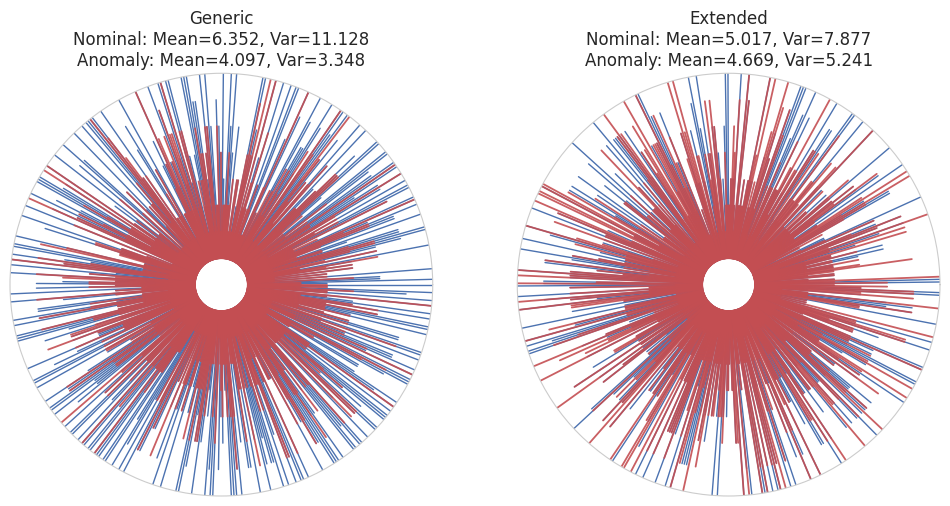

In [67]:
Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([10.,0.]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F0,np.array([-5.,-3.]),sorted=Sorted)
for j in range(len(ra)):
    ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)

ax1.set_title("Generic\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
#ax1.text(0,F0.limit+0.4,"800 Trees, full depth")

ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([10.,0.]),sorted=Sorted)
for j in range(len(rn)):
    ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F1,np.array([-5.,-3.]),sorted=Sorted)
for j in range(len(ra)):
    ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)


ax2.set_title("Extended\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

##Local Density anomaly

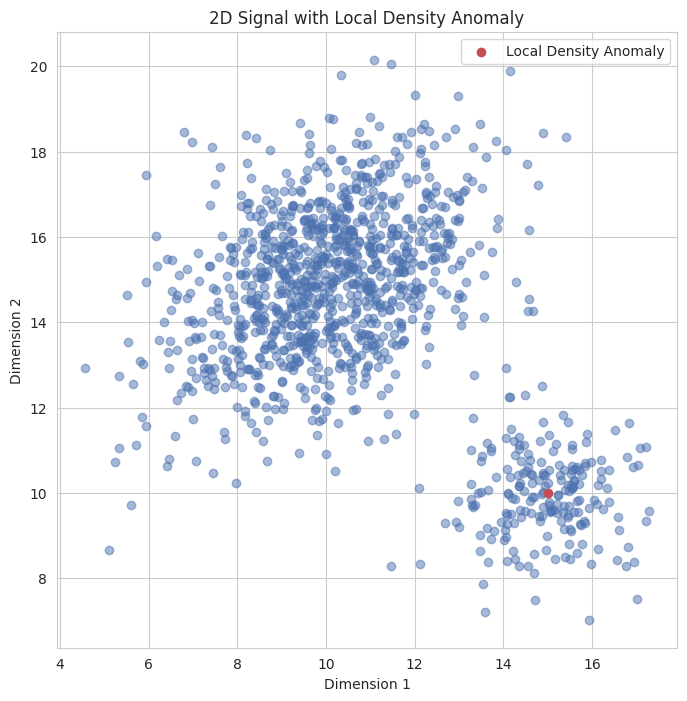

In [73]:
import numpy as np
import matplotlib.pyplot as plt

main_mean = [10, 15]
main_cov = [[3, 1], [1, 3]]
num_points_main = 1000
anomaly_mean = [15, 10]
anomaly_cov = [[1, 0], [0, 1]]
num_points_anomaly = 200
main_distribution = np.random.multivariate_normal(main_mean, main_cov, num_points_main)
anomaly_distribution = np.random.multivariate_normal(anomaly_mean, anomaly_cov, num_points_anomaly)
combined_distribution = np.vstack((main_distribution, anomaly_distribution))
plt.figure(figsize=(8, 8))
plt.scatter(combined_distribution[:, 0], combined_distribution[:, 1], color='b', alpha=0.5)
plt.scatter(anomaly_mean[0], anomaly_mean[1], color='r', label="Local Density Anomaly")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.title("2D Signal with Local Density Anomaly")
plt.grid(True)
plt.show()

In [11]:
F0=iso.iForest(combined_distribution, ntrees=500, sample_size=256, ExtensionLevel=0)#iForest
F1=iso.iForest(combined_distribution, ntrees=500, sample_size=256, ExtensionLevel=1)#EIF

NameError: ignored

In [75]:
anomaly_scores_0=F0.compute_paths(X_in=combined_distribution)# anomaly score created by iForest
anomaly_scores_1=F1.compute_paths(X_in=combined_distribution)# anomaly score created by EIF

In [109]:
#To set the threshold I used the Median Absolute Deviation (MAD) method
def compute_mad(scores):
    median = np.median(scores)
    abs_deviations = np.abs(scores - median)
    mad = np.median(abs_deviations)
    return mad

def set_threshold(scores, scaling_factor=1):
    median = np.median(scores)
    mad = compute_mad(scores)
    threshold = median + (scaling_factor * mad)
    return threshold
threshold0=set_threshold(anomaly_scores_0)
threshold1=set_threshold(anomaly_scores_1)

In [110]:
x,y=combined_distribution[:,0],combined_distribution[:,1]
anomaly_indices_0 = np.where(anomaly_scores_0 >threshold0)[0]
anomaly_indices_1 = np.where(anomaly_scores_1 >threshold1)[0]

In [111]:
anomaly_indices_0.shape

(417,)

In [112]:
anomaly_indices_1.shape

(402,)

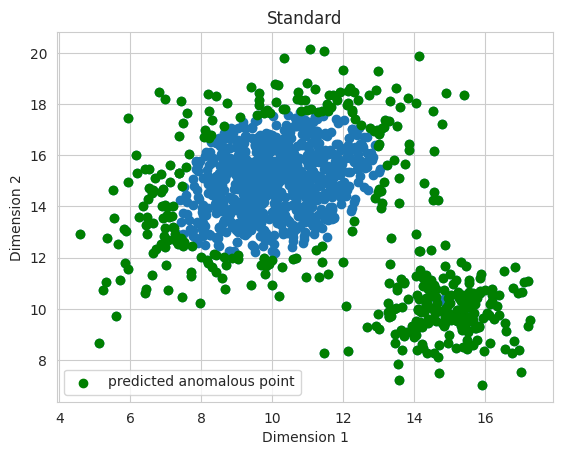

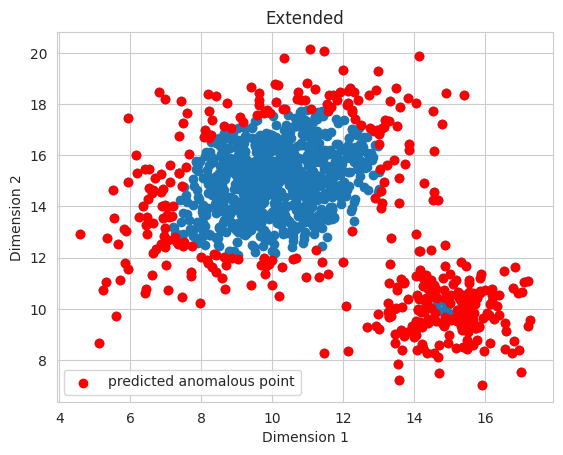

In [113]:
fig1 = plt.figure()
plt.scatter(x, y)
plt.scatter(x[anomaly_indices_0], y[anomaly_indices_0], color='green',label="predicted anomalous point")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.title('Standard')
plt.show()
fig2= plt.figure()
plt.scatter(x, y)
plt.scatter(x[anomaly_indices_1], y[anomaly_indices_1], color='red',label="predicted anomalous point")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.title('Extended')
plt.show()

In [114]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)

def getVals(forest,x,sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]),i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

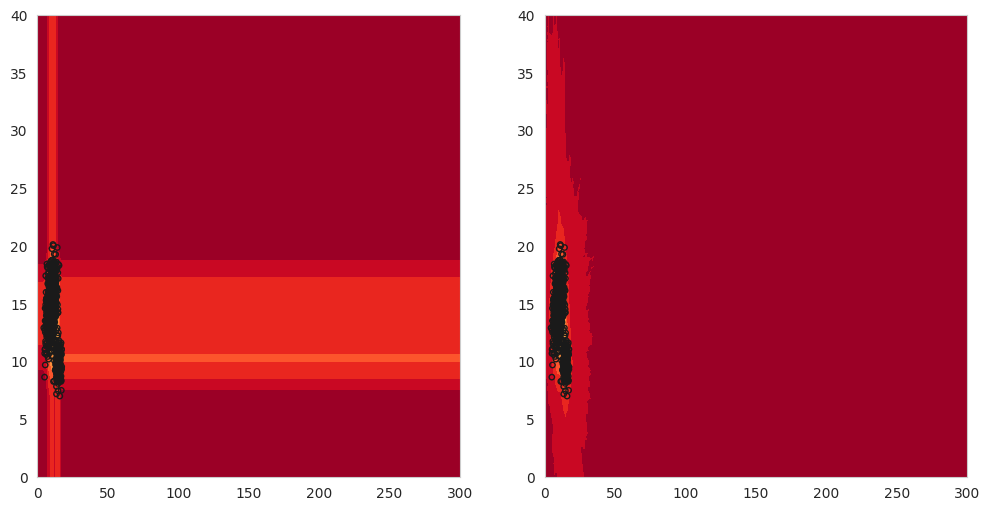

In [115]:
xx, yy = np.meshgrid(np.linspace(0, 300, 300), np.linspace(0, 40, 300))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


plt.show()

## A Deviant Numerical Spatial-Temporal Poin

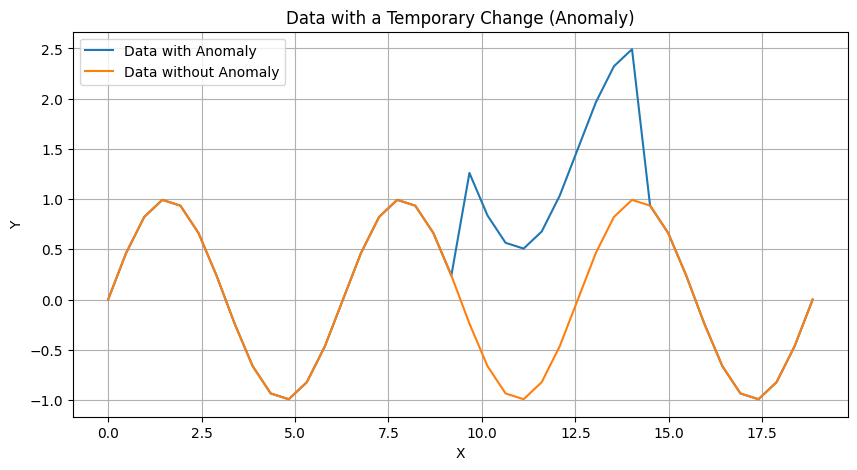

In [2]:
import numpy as np
import matplotlib.pyplot as plt
num_cycles =3
cycle_length = 40
x_regular = np.linspace(0, 2 * np.pi * num_cycles, cycle_length)
y_regular = np.sin(x_regular)

anomaly_start = cycle_length // 2
anomaly_end = cycle_length // 2 + 10 )
anomaly_amplitude = 1.5
y_with_anomaly = np.copy(y_regular)
y_with_anomaly[anomaly_start:anomaly_end] += anomaly_amplitude
plt.figure(figsize=(10, 5))
plt.plot(x_regular, y_with_anomaly, label="Data with Anomaly")
plt.plot(x_regular, y_regular, label="Data without Anomaly")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Data with a Temporary Change (Anomaly)")
plt.grid(True)
plt.show()

In [5]:
x_regular.shape,y_with_anomaly.shape

((100,), (100,))

In [3]:
combined_cycle=np.array([x_regular,y_with_anomaly])

In [12]:
F0=iso.iForest(combined_cycle, ntrees=500, sample_size=256, ExtensionLevel=0)#iForest
F1=iso.iForest(combined_cycle, ntrees=500, sample_size=256, ExtensionLevel=1)#EIF

In [ ]:
anomaly_scores_0=F0.compute_paths(X_in=combined_cycle)# anomaly score created by iForest
anomaly_scores_1=F1.compute_paths(X_in=combined_cycle)# anomaly score created by EIF